In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import speech_recognition as sr
import os 
from pydub import AudioSegment 
from pydub.silence import split_on_silence 

In [25]:
# a function that splits the audio file into chunks on each silence interval
# and applies speech recognition 
def silence_based_conversion(path): 
  
    # open the audio file stored in 
    # the local system as a wav file. 
    print("openning audio file...")
    audio = AudioSegment.from_wav(path) 
    print("audio file opened")
  
    # open a file where we will concatenate   
    # and store the recognized text 
    fh = open("recognized_text.txt", "w+") 
          
    print("splitting audio file...")
    # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(audio, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 1000, 

        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = -45
    ) 
    
    print("audio file splitted")
    print("number of chunks: ", len(chunks))


    # create a directory to store the audio chunks. 
    try: 
        os.mkdir('audio_chunks')
    except(FileExistsError): 
        pass
  
    # move into the directory to 
    # store the audio files. 
    # os.chdir('audio_chunks') 
  
    i = 0
    # process each chunk 
    for chunk in chunks: 
        
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 500) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        print("saving chunk{0}.wav".format(i)) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("../data/lectures/audio_chunks/chunk{0}.wav".format(i), bitrate ='192k', format ="wav") 

        # the name of the newly created chunk 
        filename = '../data/lectures/audio_chunks/' + 'chunk'+str(i)+'.wav'

        print("Processing chunk "+str(i)) 

        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 

        # create a speech recognition object 
        r = sr.Recognizer() 
        
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            # r.adjust_for_ambient_noise(source) 
            audio_listened = r.listen(source) 

        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file. 
            fh.write(rec+". ") 

        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 

        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 

        i += 1
        
    fh.close()
    print("all chunks processed")
  

In [26]:
def get_VAD_dictionary():
    """
    This function loads dictionary of 20_000 words, each labeled for arousal, valence and dominance
    :return: Pandas dataframe containing dictionary
    """
    filepath = "../data/NRC/NRC-VAD-Lexicon.txt"
    vad_dict = pd.read_csv(filepath,  names=["valence", "arousal", "dominance"], skiprows=45, sep='\t')
    print(vad_dict.head(5))
    print("Number of words in dictionary: ", len(vad_dict))
    return vad_dict

In [27]:
def get_vad_scores(text, vad_dict):
    """
    Tries to find words from VAD dictionary in text String. 
    :param text: Text.
    :param vad_dict: Pandas dataframe.
    :return: Dictionary of words from text file, containing VAD scores (valance, arousal, dominance) for each of them
    """
    scores = []
    text = text.replace(',', ' ')
    text = text.lower()
    words = text.split(' ')
    found_counter = 0
    for w in words:
        try:
            value = vad_dict.loc[w]
            scores.append([w, round(value[0], 2), round(value[1], 2), round(value[2], 2)])
            found_counter += 1
        except KeyError:
            pass
            scores.append([w, 0.5, 0.5, 0.5])

    print('\n'.join(str(element) for element in scores))
    vad = [score[1:] for score in scores]
    print("number of words in recognised text: ", len(words))
    print("number of words found: ", found_counter)
    return vad

In [28]:
def moving_average(a, n=30) :
    """
    This is just to smooth/average the graph. 
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [29]:
def main():
    
    # recognize speech and save it to txt file
    silence_based_conversion("../data/lectures/test2.wav")
    
    # load speech text
    with open("recognized_text.txt", "r") as file:
        text = file.read()
        
    print(text)
    
    # load VAD dictionary from csv
    vad_dict = get_VAD_dictionary()
    
    # find words from dictionary in speech text
    vad_scores = get_vad_scores(text, vad_dict)
    
    # convert to numpy array
    data = np.array(vad_scores)


    # plot graphs
    valance = data[:, 0]
    plt.plot(valance)
    plt.xlabel("valance")
    plt.show()
    
    smoothed = moving_average(valance)
    plt.plot(smoothed)
    plt.xlabel("valance smoothed")
    plt.show()
    
    arousal = data[:, 1]
    smoothed = moving_average(arousal)
    plt.plot(smoothed)
    plt.xlabel("arousal smoothed")
    plt.show()
    
    dominance = data[:, 2]
    smoothed = moving_average(dominance)
    plt.plot(smoothed)
    plt.xlabel("dominance smoothed")
    plt.show()

openning audio file...
audio file opened
splitting audio file...
audio file splitted
number of chunks:  31
saving chunk0.wav
Processing chunk 0
saving chunk1.wav
Processing chunk 1
saving chunk2.wav
Processing chunk 2
saving chunk3.wav
Processing chunk 3
saving chunk4.wav
Processing chunk 4
saving chunk5.wav
Processing chunk 5
saving chunk6.wav
Processing chunk 6
saving chunk7.wav
Processing chunk 7
saving chunk8.wav
Processing chunk 8
saving chunk9.wav
Processing chunk 9
saving chunk10.wav
Processing chunk 10
saving chunk11.wav
Processing chunk 11
saving chunk12.wav
Processing chunk 12
saving chunk13.wav
Processing chunk 13
saving chunk14.wav
Processing chunk 14
saving chunk15.wav
Processing chunk 15
saving chunk16.wav
Processing chunk 16
saving chunk17.wav
Processing chunk 17
saving chunk18.wav
Processing chunk 18
saving chunk19.wav
Processing chunk 19
saving chunk20.wav
Processing chunk 20
saving chunk21.wav
Processing chunk 21
saving chunk22.wav
Processing chunk 22
saving chunk23.w

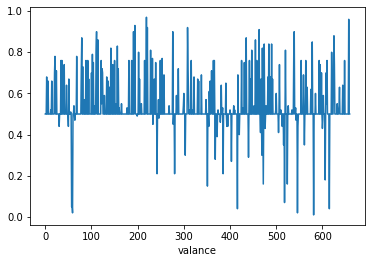

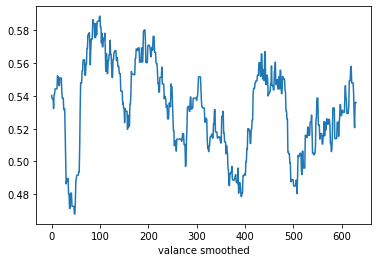

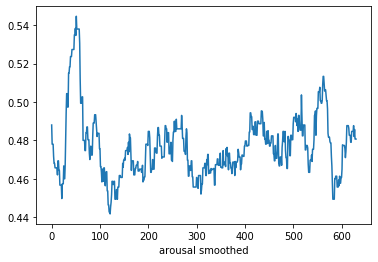

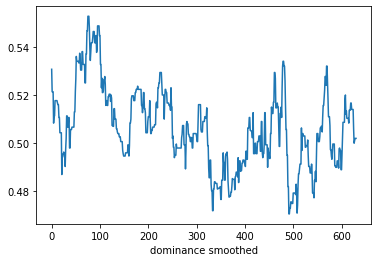

In [30]:
main()
